# Steady-state Photocurrent

In [23]:
#@markdown Step 1: Upload the file and type the file name below.
filename = '0--00003' #@param {type:"string"}
amp_factor = 200 #@param {type:"number"}
avg_length = 1000 #@param {type:"number"}
lighton_time = 0 #@param {type:"number"}
lightoff_time = 0.85 #@param {type:"number"}
use_fitting = True #@param {type:"boolean"}

#@markdown Step 2: Figure setting.
figure_title = 'HEBR_test' #@param {type:"string"}
y_max = 6 #@param {type:"number"}
y_min = -4 #@param {type:"number"}

***** 0 => Light-off ; 1 => Light-on *****
critical_value_0: 0.962 at 0.859 s
fit_critical_value_0: 0.43
fit_area_0: 0.267
half_time_0: 0.075
***** 0 => Light-off ; 1 => Light-on *****
critical_value_1: 1.111 at 0.01 s
fit_critical_value_1: 1.073
fit_area_1: 2.301
half_time_1: 0.149
Done! d(//-v-)b


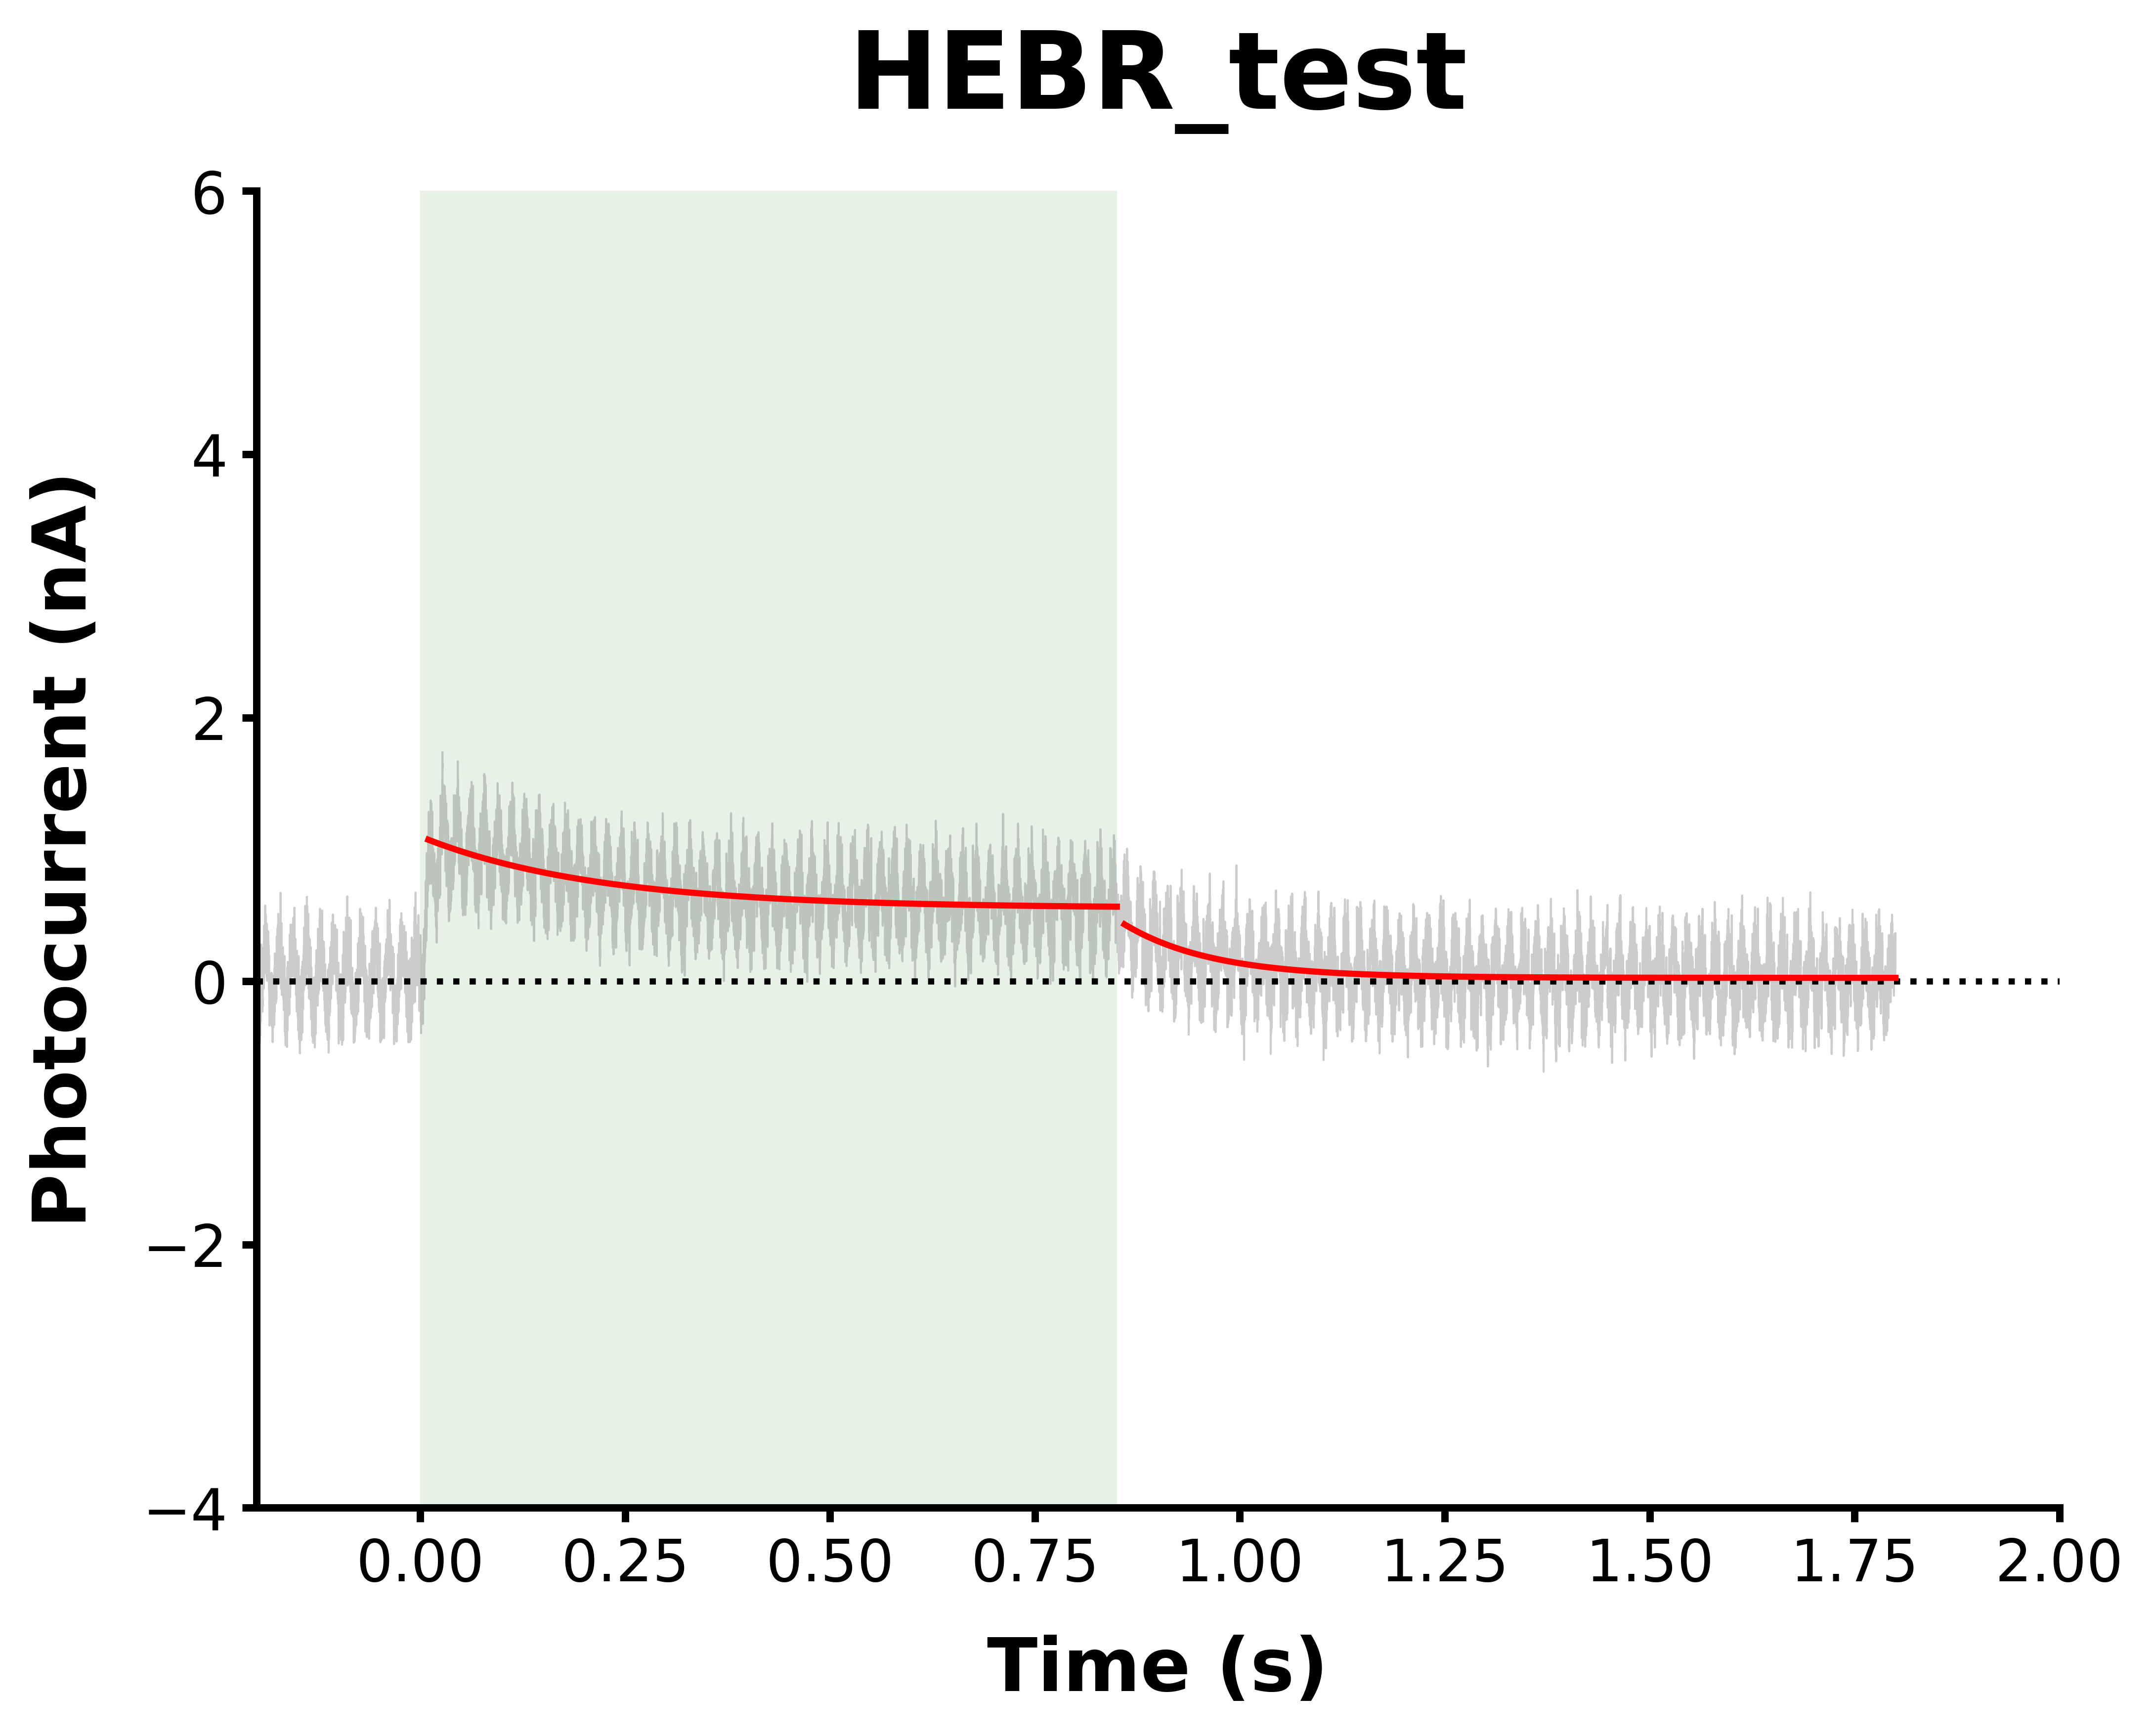

In [24]:
#@title 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


def Baseline(df, amp, num):
    shf = sum(df["Ampl"][0:num]) / num
    df["Ampl"] = [amp * (x - shf) for x in df["Ampl"]]
    return df


def Grouping(df, light_on, light_off):
    on_Ampl, on_Time, off_Ampl, off_Time = [], [], [], []
    for i in range(len(df["Time"])):
        if (light_on <= df["Time"][i] < light_off):
            on_Ampl.append(df["Ampl"][i])
            on_Time.append(df["Time"][i])
        elif (light_off <= df["Time"][i]):
            off_Ampl.append(df["Ampl"][i])
            off_Time.append(df["Time"][i])

    on = pd.DataFrame(list(zip(on_Time, on_Ampl)), columns=['Time', 'Ampl'])
    off = pd.DataFrame(list(zip(off_Time, off_Ampl)), columns=['Time', 'Ampl'])
    return off, on


def Fitting(gp, j):
    cal_ampl, cal_time = [], []

    try:
        # Find critical amplitude
        cri_ampl = max([abs(x) for x in gp["Ampl"][0:250]])

        # Find critical time from critical amplitude
        for i in range(len(gp["Time"])):
            if (abs(gp["Ampl"][i]) == cri_ampl):
                cri_time = gp["Time"][i]
                break

        # Set analysis interval
        for i in range(len(gp["Time"])):
            if (gp["Time"][i] >= cri_time):
                cal_time.append(gp["Time"][i])
                cal_ampl.append(gp["Ampl"][i])

        # Curve Fitting
        # p = plateau /plato/
        def exp_func(x, a, tau, p):
            return (a-p)*np.exp(-(x/tau))+p

        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(exp_func, cal_time, cal_ampl)

    except:
        print("Fitting failed! ~~~(.~.)>")

    else:
        fit_ampl = [exp_func(i, *popt) for i in cal_time]
        fit_cri = max(fit_ampl)
        fit_area = np.trapz(fit_ampl, dx=0.00016)
        hftime = np.log(2) * popt[1]
        sigma = np.sqrt(np.diag(pcov))
        print("***** 0 => Light-off ; 1 => Light-on *****")
        print("critical_value_{}: {} at {} s".format(
            j, round(cri_ampl, 3), round(cri_time, 3)))
        print("fit_critical_value_{}: {}".format(j, round(fit_cri, 3)))
        print("fit_area_{}: {}".format(j, round(fit_area, 3)))
        print("half_time_{}: {}".format(j, round(hftime, 3)))
        return cal_time, fit_ampl

    finally:
        pass


def Figure(df, fit_off, fit_on, ymin, ymax, light_on, light_off):
    fig, ax = plt.subplots(dpi=600, figsize=(8, 6))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(width=1.8)
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(1.8)
    font1 = {'family': 'arial', 'color':  'black',
             'weight': 'bold', 'size': 18}
    font2 = {'family': 'arial', 'color':  'black',
             'weight': 'bold', 'size': 26}
    plt.axvspan(light_on, light_off, facecolor='g', alpha=0.1)
    if use_fitting == True:
      plt.plot(df["Time"], df["Ampl"], c="grey", lw=0.5, alpha=0.4)
    else:
      plt.plot(df["Time"], df["Ampl"], c="grey", lw=0.5, alpha=1)
    plt.plot([-0.2, 2.0], [0, 0], 'k:')
    if use_fitting == True:
      plt.plot(fit_off[0], fit_off[1], 'r')
      plt.plot(fit_on[0], fit_on[1], 'r')
    plt.axis([-0.2, 2.0, ymin, ymax])   # change [xmin, xmax, ymin, ymax]
    plt.xlabel("Time (s)", fontdict=font1, labelpad=10)
    plt.ylabel("Photocurrent (nA)", fontdict=font1, labelpad=10)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(bottom=0.14, left=0.14)
    plt.title(figure_title, fontdict=font2, pad=20)



import sys
import os
input_path = '/content/'+filename+'.csv'
df = pd.read_csv(input_path, skiprows=4)
input_path = os.path.splitext(input_path)[0]


df = Baseline(df, amp_factor, avg_length)
gp = Grouping(df, lighton_time, lightoff_time)
if use_fitting == True:
  fit_off = Fitting(gp[0], 0)
  fit_on = Fitting(gp[1], 1)
else:
  fit_on, fit_off = 0, 0
Figure(df, fit_off, fit_on, y_min, y_max, lighton_time, lightoff_time)
plt.savefig(input_path+".png")
print('Done! d(//-v-)b')

You can download the resulting figure at the same place you upload! :)